Import Libraries

In [1]:
# Import necessary libraries
from sklearn.datasets import load_breast_cancer
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

Data Preprocessing

In [4]:
# Load the Breast Cancer dataset
breast_cancer = load_breast_cancer()

# Convert to DataFrame for easier manipulation
data = pd.DataFrame(data=breast_cancer.data, columns=breast_cancer.feature_names)
data['target'] = breast_cancer.target

# Check for missing values
if data.isnull().sum().sum() == 0:
    print("No missing values found in the dataset.")

# Split dataset into features and target
X = data.drop('target', axis=1)
y = data['target']

# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Display dataset information
print(f"Training set size: {X_train.shape}, Testing set size: {X_test.shape}")
print("Class distribution in training set:")
print(y_train.value_counts(normalize=True))
print("Class distribution in testing set:")
print(y_test.value_counts(normalize=True))

# Function to plot ROC curve
def plot_roc_curve(y_test, y_scores, model_name):
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')

No missing values found in the dataset.
Training set size: (455, 30), Testing set size: (114, 30)
Class distribution in training set:
target
1    0.626374
0    0.373626
Name: proportion, dtype: float64
Class distribution in testing set:
target
1    0.631579
0    0.368421
Name: proportion, dtype: float64


Part 1: K-Nearest Neighbors (KNN)

Optimal K for Euclidean distance: 8
Optimal K for Manhattan distance: 4
Optimal K for Cosine distance: 5
Classification Report for KNN (Euclidean distance):
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        42
           1       0.97      0.99      0.98        72

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

Classification Report for KNN (Manhattan distance):
              precision    recall  f1-score   support

           0       0.95      0.93      0.94        42
           1       0.96      0.97      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114

Classification Report for KNN (Cosine distance):
              precision    recall  f1-score   support

           0       0.95      0.93

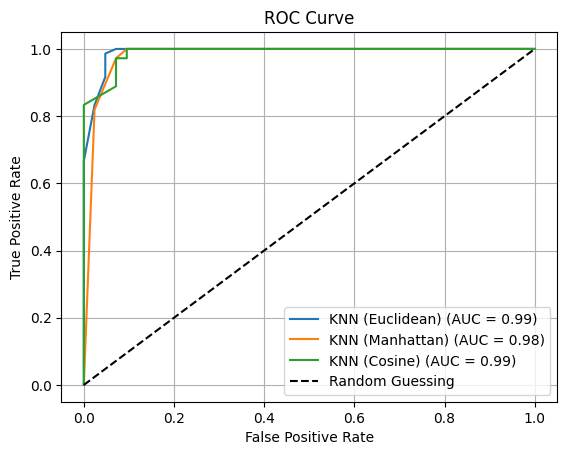

In [14]:
# Initialize KNN classifiers with different distance metrics
knn_euclidean = KNeighborsClassifier(metric='euclidean')
knn_manhattan = KNeighborsClassifier(metric='manhattan')
knn_cosine = KNeighborsClassifier(metric='cosine')

# List of classifiers
classifiers = {
    'Euclidean': knn_euclidean,
    'Manhattan': knn_manhattan,
    'Cosine': knn_cosine
}

# Determine the optimal value of K using cross-validation
k_range = range(1, 31)
cv_scores = {metric: [] for metric in classifiers.keys()}

for k in k_range:
    for metric, clf in classifiers.items():
        clf.n_neighbors = k
        scores = cross_val_score(clf, X_train_scaled, y_train, cv=5, scoring='accuracy')
        cv_scores[metric].append(scores.mean())

# Find the optimal K for each metric
optimal_k = {metric: k_range[np.argmax(scores)] for metric, scores in cv_scores.items()}

# Print the optimal K for each metric
for metric, k in optimal_k.items():
    print(f"Optimal K for {metric} distance: {k}")
# Compare the performance of Logistic Regression with KNN
for metric, clf in classifiers.items():
    clf.n_neighbors = optimal_k[metric]
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Classification Report for KNN ({metric} distance):\n{classification_report(y_test, y_pred)}")

# KNN Classifiers with ROC curves
for metric, clf in classifiers.items():
    clf.n_neighbors = optimal_k[metric]
    clf.fit(X_train_scaled, y_train)
    y_scores = clf.predict_proba(X_test_scaled)[:, 1]  # Get probabilities for the positive class
    plot_roc_curve(y_test, y_scores, f'KNN ({metric})')

# Show final ROC plot
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')  # Diagonal line
plt.legend(loc='lower right')
plt.grid()
plt.show()

Part 2: Logistic Regression

Accuracy with L1 regularization: 0.9912
Classification Report for L1 regularization:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        42
           1       0.99      1.00      0.99        72

    accuracy                           0.99       114
   macro avg       0.99      0.99      0.99       114
weighted avg       0.99      0.99      0.99       114

Accuracy with L2 regularization: 0.9825
Classification Report for L2 regularization:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        42
           1       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



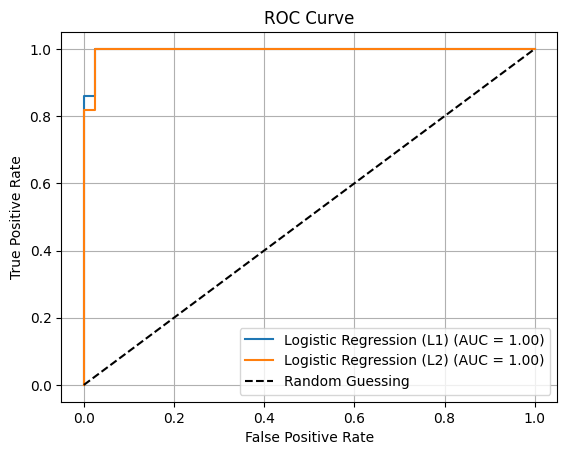

In [13]:
# Initialize Logistic Regression models with different regularization techniques
logreg_l1 = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
logreg_l2 = LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000)

# List of classifiers
logreg_classifiers = {
    'L1': logreg_l1,
    'L2': logreg_l2
}

# Train and evaluate Logistic Regression models
for reg, clf in logreg_classifiers.items():
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy with {reg} regularization: {accuracy:.4f}")
    print(f"Classification Report for {reg} regularization:\n{classification_report(y_test, y_pred)}")

# Logistic Regression with ROC curves
for reg, clf in logreg_classifiers.items():
    clf.fit(X_train_scaled, y_train)
    y_scores = clf.predict_proba(X_test_scaled)[:, 1]
    plot_roc_curve(y_test, y_scores, f'Logistic Regression ({reg})')

# Show final ROC plot
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')  # Diagonal line
plt.legend(loc='lower right')
plt.grid()
plt.show()


Part 3: Support Vector Machines (SVM)

Accuracy with Linear kernel: 0.9737
Classification Report for Linear kernel:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96        42
           1       0.99      0.97      0.98        72

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

Accuracy with Polynomial kernel: 0.9123
Classification Report for Polynomial kernel:
              precision    recall  f1-score   support

           0       1.00      0.76      0.86        42
           1       0.88      1.00      0.94        72

    accuracy                           0.91       114
   macro avg       0.94      0.88      0.90       114
weighted avg       0.92      0.91      0.91       114

Accuracy with RBF kernel: 0.9825
Classification Report for RBF kernel:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        42
    

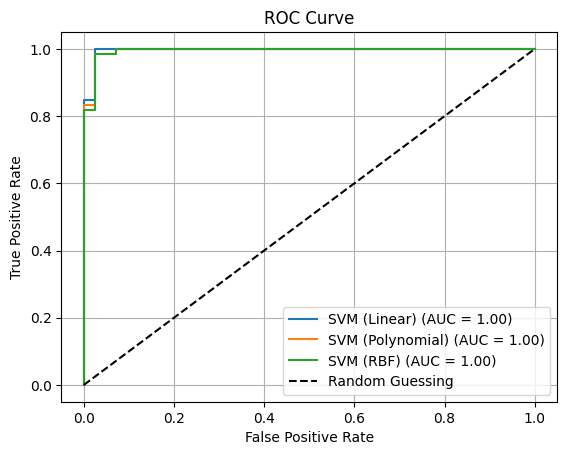

In [12]:
# Initialize SVM classifiers with different kernels
svm_linear = SVC(kernel='linear')
svm_poly = SVC(kernel='poly')
svm_rbf = SVC(kernel='rbf')

# List of classifiers
svm_classifiers = {
    'Linear': svm_linear,
    'Polynomial': svm_poly,
    'RBF': svm_rbf
}

# Train and evaluate SVM models
for kernel, clf in svm_classifiers.items():
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy with {kernel} kernel: {accuracy:.4f}")
    print(f"Classification Report for {kernel} kernel:\n{classification_report(y_test, y_pred)}")

# SVM Classifiers with ROC curves
for kernel, clf in svm_classifiers.items():
    clf.fit(X_train_scaled, y_train)
    y_scores = clf.decision_function(X_test_scaled)  # Use decision function for ROC
    plot_roc_curve(y_test, y_scores, f'SVM ({kernel})')

# Show final ROC plot
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')  # Diagonal line
plt.legend(loc='lower right')
plt.grid()
plt.show()

C:\Users\adams\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy with AdaBoost: 0.9561
Classification Report for AdaBoost:
              precision    recall  f1-score   support

           0       0.97      0.90      0.94        42
           1       0.95      0.99      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114

Accuracy with Random Forest: 0.9474
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        42
           1       0.96      0.96      0.96        72

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



C:\Users\adams\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


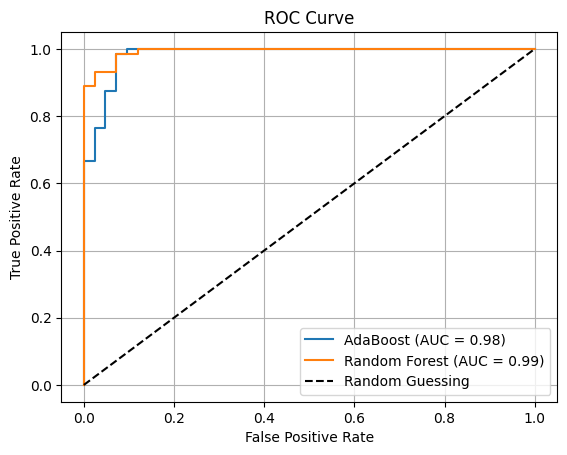

In [11]:
# Initialize ensemble classifiers
adaboost = AdaBoostClassifier(n_estimators=100)
random_forest = RandomForestClassifier(n_estimators=100)

# List of classifiers
ensemble_classifiers = {
    'AdaBoost': adaboost,
    'Random Forest': random_forest
}

# Train and evaluate ensemble models
for method, clf in ensemble_classifiers.items():
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy with {method}: {accuracy:.4f}")
    print(f"Classification Report for {method}:\n{classification_report(y_test, y_pred)}")

# Ensemble Methods with ROC curves
for method, clf in ensemble_classifiers.items():
    clf.fit(X_train_scaled, y_train)
    y_scores = clf.predict_proba(X_test_scaled)[:, 1]
    plot_roc_curve(y_test, y_scores, method)
    
# Show final ROC plot
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')  # Diagonal line
plt.legend(loc='lower right')
plt.grid()
plt.show()
